In [1]:
# get imports
import dsbhelper as dsb
import random
from matplotlib import pyplot as plt
import cv2
import numpy as np
from scipy.ndimage.measurements import center_of_mass
from skimage.segmentation import random_walker, active_contour
from skimage.morphology import watershed, binary_dilation
from skimage.filters import gaussian, median
from skimage import measure
from skimage.feature import peak_local_max
from scipy import ndimage

/Users/farrar/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make a constant for data location
TRAIN_DATA = 'stage1_train'

<H2>Get Some Specimen Data</H2>

In [3]:
# get a random specimen
specimen_ids = dsb.get_specimen_ids(TRAIN_DATA)
specimen_id = random.choice(specimen_ids)
#specimen_id = 'e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8'
print (specimen_id)

8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c3547bbbd6c65ac0d83


7


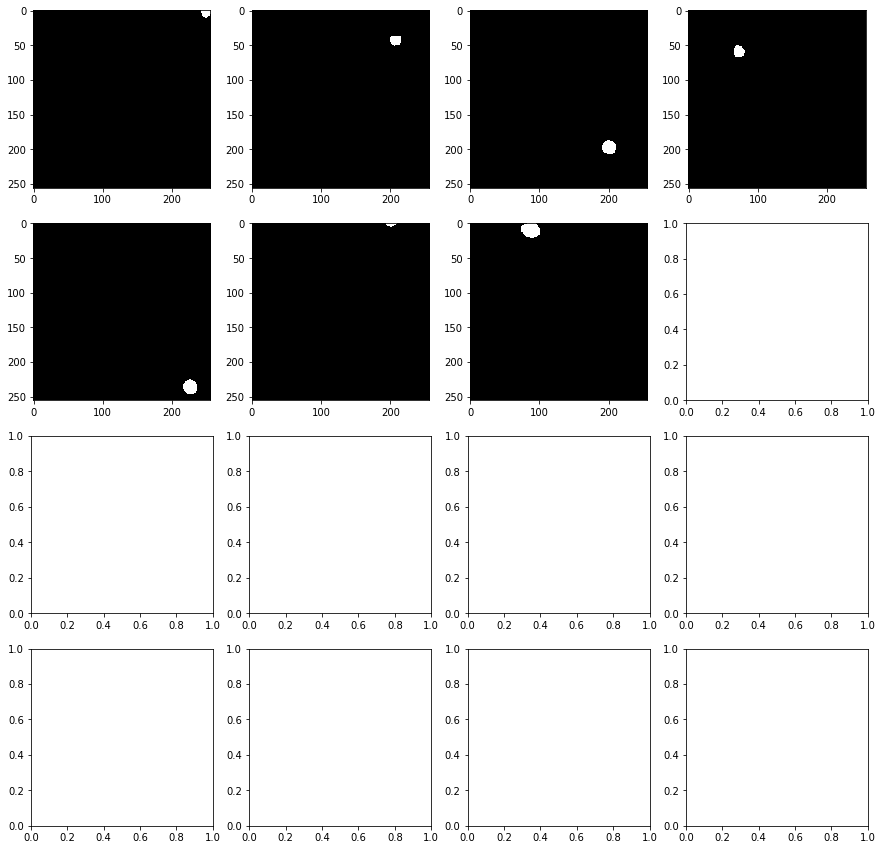

In [4]:
# get the specimen masks and the first 16
masks = dsb.get_specimen_masks(TRAIN_DATA, specimen_id)
print(len(masks))
#nrows = int(len(masks)/4) + 1
nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0

for row in range(nrows):
    for col in range(4):
        if i < len(masks):
            axarr[row, col].imshow(masks[i], cmap='gray')
        i += 1

31875


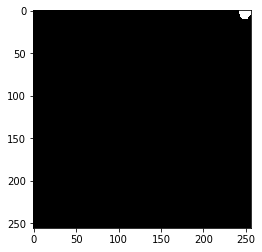

In [5]:
# show a single image
print (masks[0].sum())
plt.imshow(masks[0], cmap='gray')

<H2>Develop Mask Using Watershed</H2>

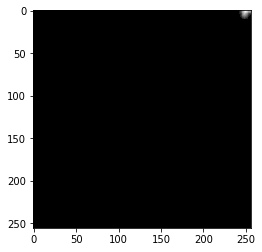

In [6]:
dist_transform = cv2.distanceTransform(masks[0], cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap='gray')

In [7]:
mask_max = dist_transform[dist_transform > 0]
print (mask_max)

[1.        2.        3.        4.        5.        6.        7.
 8.        7.7969    7.1937995 6.5906997 6.3938    6.1969    6.
 1.        2.        3.        4.        5.        6.        7.
 7.7969    7.        6.3968997 5.7938    5.3938    5.1969    5.
 1.        2.        3.        4.        4.9968996 5.7938    6.5906997
 7.        6.3968997 5.6       4.9968996 4.3938    4.1969    4.
 1.        2.        2.8       3.5969    4.3938    5.3938    6.3938
 6.3968997 5.6       4.9968996 4.2       3.5969    3.1969    3.
 1.        1.4       2.1969    3.1969    4.1969    5.1969    6.1969
 5.6       4.9968996 4.2       3.5969    2.8       2.1969    2.
 1.        2.        3.        4.        4.9968996 5.3938    4.9968996
 4.2       3.5969    2.8       2.1969    1.4       1.        1.
 2.        2.8       3.5969    4.1969    4.3938    4.1969    3.5969
 2.8       2.1969    1.4       1.        1.        1.4       2.1969
 2.8       3.1969    3.5969    3.1969    2.8       2.1969    1.4
 1.      

In [8]:
print (np.max(mask_max))

8.0


0
255
255
36720


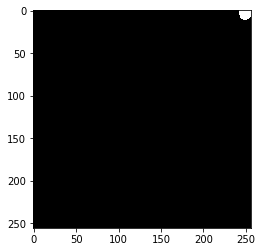

In [9]:
# dilate the mask to get sure background
mask = masks[0]
print(mask.min())
print(mask.max())
kernel = np.ones((2,2), np.uint8)
sure_bg = cv2.dilate(mask, kernel, iterations=1)
#sure_bg = binary_dilation(mask, kernel)
print(sure_bg.max())
print(sure_bg.sum())
plt.imshow(sure_bg, cmap='gray')


255.0


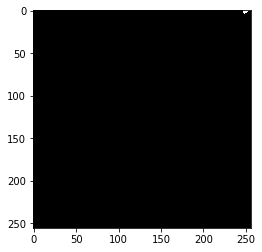

In [10]:
# threshold with a distance transform to get the sure foreground
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
print(sure_fg.max())
plt.imshow(sure_fg, cmap='gray')

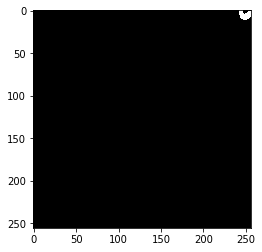

In [11]:
# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

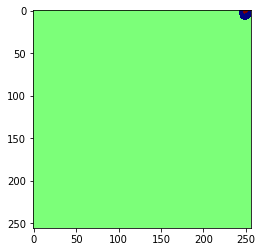

In [12]:
# Label with markers
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='jet')

(256, 256, 3)
2
-1
(256, 256)
(256, 256, 3)
255
0
(256, 256)


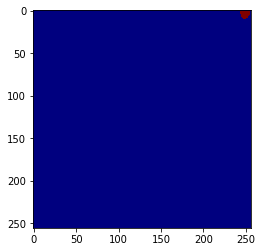

In [13]:
# show the watershed image
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
new_mask = cv2.watershed(mask, markers)
print(mask.shape)
print(new_mask.max())
print(new_mask.min())
print(new_mask.shape)

new_mask[new_mask==-1] = 1
new_mask = new_mask - 1
new_mask = new_mask * 255
print(mask.shape)
print(new_mask.max())
print(new_mask.min())
print(new_mask.shape)
plt.imshow(new_mask, cmap='jet')

(256, 256)
22440
31875


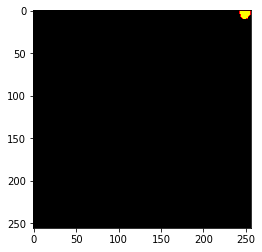

In [14]:
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
print(mask.shape)
print(np.sum(new_mask))
print(np.sum(mask))

i = np.zeros((new_mask.shape[0], new_mask.shape[1],3), dtype=np.uint8)
i[:, :, 0] = mask
i[:, :, 1] = new_mask
plt.imshow(i)

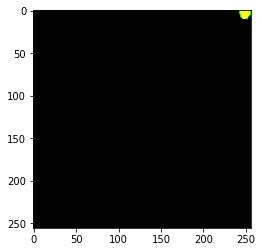

In [15]:
# ---------------------------------------------------------------------
# Creates a new mask using watershed methodology
# inspired by: Allen Goodman in this post:
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130
# ---------------------------------------------------------------------
def watershed_mask(mask):
    
    # dilate the mask to get sure background
    kernel = np.ones((2,2), np.uint8)
    sure_bg = cv2.dilate(mask, kernel, iterations=1)
    
    # threshold with a distance transform to get the sure foreground
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Find the unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Label with markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1         # Add one to all labels so that sure background is not 0, but 1
    markers[unknown==255] = 0     # Now, mark the region of unknown with zero

    # compute the watershed image
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    new_mask = cv2.watershed(mask, markers)
    new_mask[new_mask == -1] = 1
    new_mask = new_mask - 1

    if new_mask.max() == 1:
        new_mask = new_mask * 255

    return new_mask

# unit test --------------------
new_mask = watershed_mask(masks[0])
i = np.zeros((new_mask.shape[0], new_mask.shape[1],3), dtype=np.uint8)
i[:, :, 0] = new_mask
i[:, :, 1] = mask
plt.imshow(i)

<H2>Develop Mask Using Random Walker Segmentation</H2>

In [16]:
mask = masks[0]
print(mask.sum())
centroid = center_of_mass(mask)
print (centroid)

31875
(4.152, 248.432)


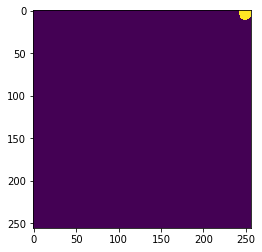

In [17]:
mask = masks[0]
kernel = np.ones((2,2), np.uint8)
sure_bg = cv2.dilate(mask, kernel, iterations=1)
plt.imshow(sure_bg)

0.0
9.0
7.5906997


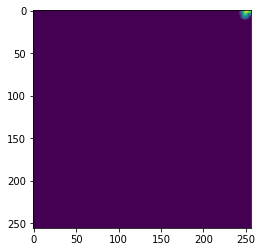

In [18]:
dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
print(dist_transform.min())
print(dist_transform.max())
centroid = center_of_mass(dist_transform)
centroid_pixel_value = dist_transform[int(centroid[0])][int(centroid[1])]
print (centroid_pixel_value)
plt.imshow(dist_transform)

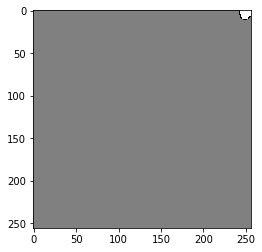

In [19]:
markers = np.zeros(mask.shape, dtype=np.uint8)
markers[dist_transform >= 0.2 * centroid_pixel_value] = 2
markers[dist_transform < 0.1 * centroid_pixel_value] = 1
plt.imshow(markers, cmap='gray')

(256, 256)
1
2
0
1


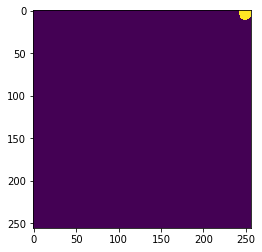

In [20]:
new_mask = random_walker(sure_bg, markers)
print(new_mask.shape)
print(new_mask.min())
print(new_mask.max())
new_mask = new_mask - 1
print(new_mask.min())
print(new_mask.max())
new_mask = new_mask * 255
plt.imshow(new_mask)

31875
36720


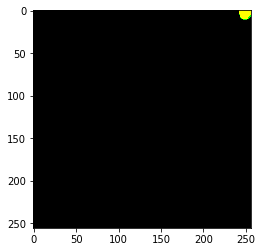

In [21]:
#mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
if np.max(mask) == 1:
    mask = mask * 255
    
print(np.sum(mask))
print(np.sum(new_mask))
i = np.zeros((new_mask.shape[0], new_mask.shape[1], 3), dtype=np.uint8)
i[:, :, 0] = mask
i[:, :, 1] = new_mask
plt.imshow(i, cmap='gray')

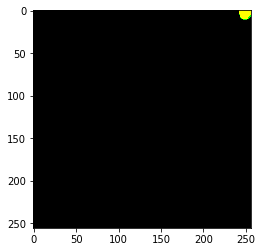

In [22]:
# ---------------------------------------------------------------------
# Creates a new mask using random walk methodology
# inspired by: Allen Goodman in this post:
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130
# ---------------------------------------------------------------------
def random_walk_mask(mask):
        
    # dilate the mask to get sure background
    kernel = np.ones((2,2), np.uint8)
    sure_bg = cv2.dilate(mask, kernel, iterations=1)
    
    # do a distance transformation on the mask
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
    
    # get the centroid pixel value
    centroid = center_of_mass(dist_transform)
    centroid_pixel_value = dist_transform[int(centroid[0])][int(centroid[1])]
    
    # get markers for the random_walk mask
    markers = np.zeros(mask.shape, dtype=np.uint8)
    markers[dist_transform >= 0.2 * centroid_pixel_value] = 2
    markers[dist_transform < 0.1 * centroid_pixel_value] = 1

    
    new_mask = random_walker(sure_bg, markers)
    new_mask = new_mask - 1
    if new_mask.max() == 1:
        new_mask = (new_mask * 255).astype(np.uint8) 
    else:
        new_max = new_max.astype(np.uint8)
    
    return new_mask

# unit test -------------------------
mask = masks[0]
new_mask = random_walk_mask(mask)
i = np.zeros((new_mask.shape[0], new_mask.shape[1],3), dtype=np.uint8)
if np.max(mask) == 1:
    mask = mask * 255
i[:, :, 0] = mask
i[:, :, 1] = new_mask
plt.imshow(i)

mk shape -> (256, 256)
mk max   -> 255
mk min   -> 0
mk sum   -> 31875
mk type  -> uint8
rw shape -> (256, 256)
rw max   -> 255
rw min   -> 0
rw sum   -> 36720
rw type  -> uint8
ws shape -> (256, 256)
ws max   -> 255
ws min   -> 0
ws sum   -> 26520
ws type  -> int32


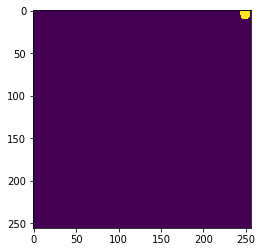

In [23]:
# try random walk followed by watershed
mask = masks[0]
print ('mk shape -> {}'.format(mask.shape))
print ('mk max   -> {}'.format(mask.max()))
print ('mk min   -> {}'.format(mask.min()))
print ('mk sum   -> {}'.format(mask.sum()))
print ('mk type  -> {}'.format(mask.dtype))
rw = random_walk_mask(mask)
print ('rw shape -> {}'.format(rw.shape))
print ('rw max   -> {}'.format(rw.max()))
print ('rw min   -> {}'.format(rw.min()))
print ('rw sum   -> {}'.format(rw.sum()))
print ('rw type  -> {}'.format(rw.dtype))
ws = watershed_mask(rw)
print ('ws shape -> {}'.format(ws.shape))
print ('ws max   -> {}'.format(ws.max()))
print ('ws min   -> {}'.format(ws.min()))
print ('ws sum   -> {}'.format(ws.sum()))
print ('ws type  -> {}'.format(ws.dtype))
plt.imshow(ws)

<H2>Develop Mask Using Active Contours</H2>

In [24]:
mask = masks[0]
centroid = center_of_mass(mask)
print (centroid)
print (mask.sum())
# note that first coord is vertical, the cartesian 'y'

(4.152, 248.432)
31875


In [25]:
# get a set of coordinates in a circle
s = np.linspace(0, 2*np.pi, 400)
x = int(centroid[1]) + 30*np.cos(s)
y = int(centroid[0]) + 30*np.sin(s)
base_circle = np.array([x, y]).T

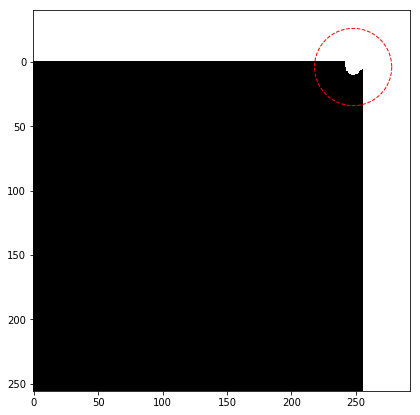

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mask, cmap=plt.cm.gray)
ax.plot(base_circle[:, 0], base_circle[:, 1], '--r', lw=1)

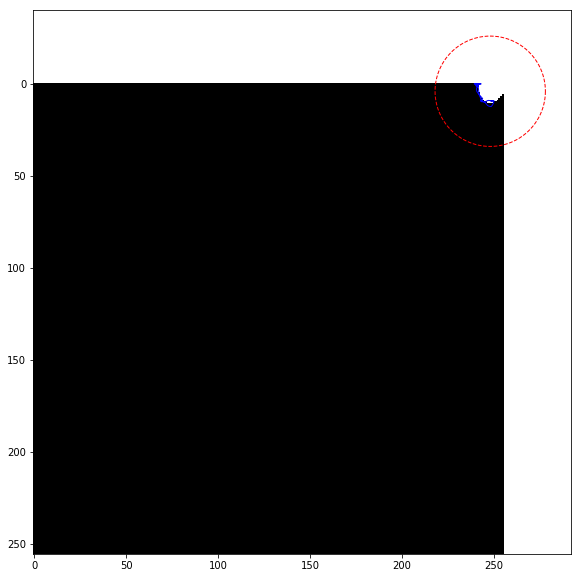

In [27]:
# alpha -> snake length, higher values make the contour contract faster
# beta  -> smoothness, higher values make the contour smoother
# w_line-> attraction to brightness, negative numbers attract to darkness
# w_edge-> attraction to edge, negative numbers repel from edges
# gamma -> explicit time stepping parameter
# max_interations -> number of iterations to optimize
# convergence -> stopping criteria

blurred_mask = gaussian(mask,2)
contour = active_contour(blurred_mask, base_circle, alpha=0.009, beta=1000, gamma=0.001)

# note: contour returns the horizontal coordinate first, the cartesian 'x'
# this is different than numpy's shape, and center_of_mass which provides 
# the vertical (cartesian 'y') first
rectified_contour = []
for coord in contour:
    if coord[0] < 0:
        coord[0] = 0
    elif coord[0] > mask.shape[1]:
        coord[0] = mask.shape[1]
    if coord[1] < 0:
        coord[1] = 0
    elif coord[1] > mask.shape[0]:
        coord[1] = mask.shape[0]
    rectified_contour.append(coord)
    
contour = np.asarray(rectified_contour)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask, cmap=plt.cm.gray)
ax.plot(base_circle[:, 0], base_circle[:, 1], '--r', lw=1)
ax.plot(contour[:, 0], contour[:, 1], '-b', lw=1)

4590.0


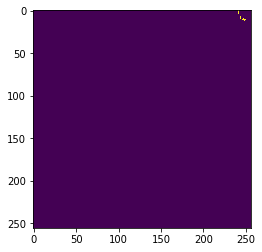

In [28]:
# convert contour to a mask
contour = np.fliplr(contour)
new_mask = measure.grid_points_in_poly(mask.shape, contour).astype(np.uint8)
print(new_mask.sum()*255)
plt.imshow(new_mask)

68340
66045


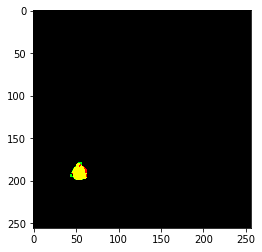

In [37]:
# ---------------------------------------------------------------------
# Creates a new mask using active contours methodology
# inspired by: Allen Goodman in this post:
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130
# ---------------------------------------------------------------------
def active_contour_mask(mask, blur_fn):

    # get the centroid of this mask
    centroid = center_of_mass(mask)

    # get a bounding circle
    s = np.linspace(0, 2*np.pi, 400)
    x = int(centroid[1]) + 30*np.cos(s)
    y = int(centroid[0]) + 30*np.sin(s)
    base_circle = np.array([x, y]).T

    if blur_fn == 'gaussian':
        blurred_mask = gaussian(mask, 2)
    elif blur_fn == 'median':
        kernel = np.ones((1,1), np.uint8)
        blurred_mask = median(mask, kernel)
    else:
        print('{} blur function not implemented.  Try gaussian...'.format(blur_fn))

    
    # calculate the active contour    
    contour = active_contour(blurred_mask, base_circle, alpha=0.009, beta=1000, gamma=0.001)

    # note: contour returns the horizontal coordinate first, the cartesian 'x'
    # this is different than numpy's shape, and center_of_mass which provides 
    # the vertical (cartesian 'y') first
    rectified_contour = []
    for coord in contour:
        if coord[0] < 0:
            coord[0] = 0
        elif coord[0] > mask.shape[1]:
            coord[0] = mask.shape[1]
        if coord[1] < 0:
            coord[1] = 0
        elif coord[1] > mask.shape[0]:
            coord[1] = mask.shape[0]
        rectified_contour.append(coord)
    
    contour = np.asarray(rectified_contour)

    # convert contour to a mask (see note above for explanation re: np.fliplr below)
    contour = np.fliplr(contour)
    new_mask = measure.grid_points_in_poly(mask.shape, contour).astype(np.uint8)
    
    new_mask = new_mask * 255
    
    return new_mask

# unit test ------------------------
mask = masks[0]
new_mask = active_contour_mask(mask, 'median')
i = np.zeros((new_mask.shape[0], new_mask.shape[1], 3), dtype=np.uint8)
if np.max(new_mask) == 1:
    new_mask = new_mask * 255
    
print(new_mask.sum())
print(masks[0].sum())
i[:, :, 0] = mask
i[:, :, 1] = new_mask
plt.imshow(i)


mk shape -> (256, 256)
mk max   -> 255
mk min   -> 0
mk sum   -> 31875
mk type  -> uint8
ac shape -> (256, 256)
ac max   -> 255
ac min   -> 0
ac sum   -> 4590
ac type  -> uint8
ws shape -> (256, 256)
ws max   -> 3
ws min   -> 0
ws sum   -> 40
ws type  -> int32


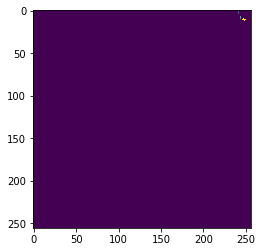

In [30]:
# try active contours followed by watershed
mask = masks[0]
print ('mk shape -> {}'.format(mask.shape))
print ('mk max   -> {}'.format(mask.max()))
print ('mk min   -> {}'.format(mask.min()))
print ('mk sum   -> {}'.format(mask.sum()))
print ('mk type  -> {}'.format(mask.dtype))
ac = active_contour_mask(mask, 'gaussian')
print ('ac shape -> {}'.format(ac.shape))
print ('ac max   -> {}'.format(ac.max()))
print ('ac min   -> {}'.format(ac.min()))
print ('ac sum   -> {}'.format(ac.sum()))
print ('ac type  -> {}'.format(ac.dtype))
ws = watershed_mask(ac)
print ('ws shape -> {}'.format(ws.shape))
print ('ws max   -> {}'.format(ws.max()))
print ('ws min   -> {}'.format(ws.min()))
print ('ws sum   -> {}'.format(ws.sum()))
print ('ws type  -> {}'.format(ws.dtype))
plt.imshow(ws)

(256, 256)


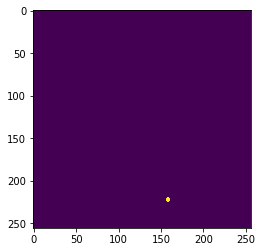

In [45]:
specimen_id = '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'
masks = dsb.get_specimen_masks(TRAIN_DATA, specimen_id)
plt.imshow(masks[5])
print (masks[5].shape)

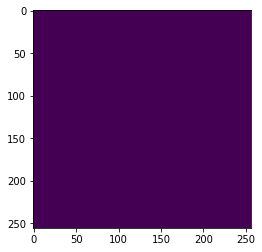

In [43]:
acm_mask = active_contour_mask(masks[6], blur_fn='gaussian')
plt.imshow(acm_mask)